# add_images_to_transcript

The purpose of this notebook is to break a TED transcript down into
one block per slide, and then to generate an appropriate image for
each slide.

## Imports

In [1]:
import requests
import json
from io import BytesIO

import openai
from IPython.display import display
from PIL import Image

## Constants

In [19]:
TEXT2IMG_URL = 'https://stablediffusionapi.com/api/v3/text2img'

## Load in API keys

In [17]:
# Stable diffusion.
with open('config.json') as f:
    stable_diffusion_key = json.load(f)['stable_diffusion_key']

In [18]:
# Load in the OpenAI API key.
with open('config.json') as f:
    openai.api_key = json.load(f)['api_key']

## Load in a sample article and topic

In [2]:
with open('example_transcript_1_french_architecture.json') as f:
    data = json.load(f)
topic = data['topic']
transcript = data['transcript']

## Break the transcript into blocks, one per slide

In [9]:
paragraphs = [para for para in transcript.split('\n') if len(para.strip()) > 0]

In [15]:
# Re-combine blocks that are too short.
# For example, we don't want one image for a single short sentence.
blocks = [paragraphs[0]]
for para in paragraphs[1:]:
    if len(blocks[-1]) < 340:
        blocks[-1] += ('\n\n' + para)
    else:
        blocks.append(para)

## Set up image-creation support

In [22]:
with open('betterfy_prompt.txt') as f:
    betterfy_prompt = f.read()

In [23]:
def get_improved_image_prompt(init_prompt):
    gpt_prompt = betterfy_prompt.replace('@post', init_prompt)

In [24]:
def get_gpt_response(prompt, num_reply_tokens=7_000):
    return openai.ChatCompletion.create(
        model = 'gpt-4-32k',
        messages = [
            {
                'role': 'user',
                'content': prompt
            }
        ],
        max_tokens = num_reply_tokens,
        top_p = 1.0,
        frequency_penalty = 0.0,
        presence_penalty = 0.0
    )['choices'][0]['message']['content']

In [34]:
def ask_for_image_url(
    prompt,
    width=512,
    height=512,
    num_inference_steps=31,
    enhance_prompt='yes',
    upscale='no'
):

    # This is saved after each call to assist
    # in debugging.
    global image_to_text_response
    
    req_obj = {
        'key': stable_diffusion_key,
        'prompt': prompt,
        'width': width,
        'height': height,
        'samples': 1,
        'num_inference_steps': num_inference_steps,
        'enhance_prompt': enhance_prompt,
        'upscale': upscale
    }
    print(req_obj)
    payload = json.dumps(req_obj)

    headers = {
      'Content-Type': 'application/json'
    }

    image_to_text_response = requests.request('POST', TEXT2IMG_URL, headers=headers, data=payload)
    text = image_to_text_response.text
    data = json.loads(text)

    return data['output'][0]

In [26]:
def display_image_from_url(url):
    ''' Downloads and displays an image from a given URL. '''
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

## Cells below here were scratch work (ignore)

In [27]:
# Try to generate an image for block 1.
blocks[0]

"Ladies and gentlemen, it's a pleasure to be here today to talk to you about a topic that is at once steeped in history, but full of potential for the future: the architecture of France. It's not just an exploration of aesthetics or engineering; French architecture offers a compelling narrative of the country's spirit, values, and evolution. As we venture to the future of French architecture, let's start by examining its storied past."

In [29]:
# Maybe block 1 is special; just the topic itself.
#
# So I'll move onto block 2 for now.

In [30]:
blocks[1]

"If you've visited Paris, you've seen firsthand the chronicles of architectural achievement, from the Middle Ages to the 21st century. Paris was the birthplace of the Gothic style, evident in the majestic Cathedral Notre-Dame de Paris, and later gave the world the Art Nouveau style, with its organic and flowing designs. The city has witnessed a dramatic interplay of styles that represented different eras: the French Renaissance, Classical revival, the exuberant Belle Époque, and innovative Art Deco. Landmarks such as the Grand Palais stand testament to this interweaving of history, style, and innovation. "

Generating image prompt .. done!
Generating the image .. 
{'key': 'yDSzK2ZFFqRrdcZwK1qsjyof0tF0RtSwW3WAI2FTQjeqBdIXVCXeFLYL2jIY', 'prompt': "Photorealistic Images: {An overview of Paris showcasing its architectural evolution through different eras. The Gothic style of the Cathedral Notre-Dame de Paris, the organic designs of Art Nouveau, representation of French Renaissance and Classical revival, and hints of Belle Époque and Art Deco styles should be evident. Landmarks such as the Grand Palais showing the interweaving of history, style, and innovation can be included}, Digital Photograph, Outdoor, late afternoon light showing the golden hue on the structures, Inspiration from travel photography on Behance, Camera: Canon EOS 5D Mark IV, Lens: Canon EF 24-105mm f/4L IS II USM, Wide Shot, Render: 8K resolution, High details with HDR rendering with balanced contrast (historical architecture:1.4).\n\nArtistic Image Types: Digital Painting, {An artist's interpretation of the rich architectu

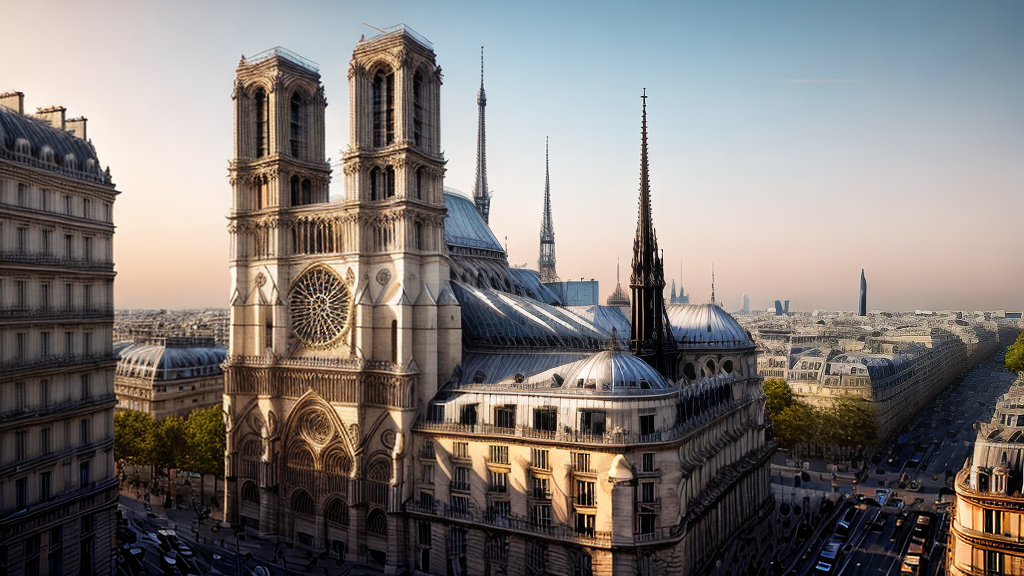

In [35]:
init_prompt = blocks[1]

# Make the image prompt.
gpt_prompt = betterfy_prompt.replace('@post', init_prompt)
print('Generating image prompt .. ', end='', flush=True)
gpt_reply = get_gpt_response(gpt_prompt)
print('done!')

# Generate the image.
print('Generating the image .. ')
img_url = ask_for_image_url(gpt_reply, num_inference_steps=51, width=1024, height=576, enhance_prompt='no')
img = display_image_from_url(img_url)
print('.. done!')
display(img)

Generating image prompt .. done!
Generating the image .. 
{'key': 'yDSzK2ZFFqRrdcZwK1qsjyof0tF0RtSwW3WAI2FTQjeqBdIXVCXeFLYL2jIY', 'prompt': 'Photorealistic Images: {A 3D rendered image that depicts a futuristic French city skyline as a representation of French architecture on the brink of a new era. The urban landscape should include a multitude of futuristic buildings that mirror the traditional architectural styles of France, like Gothic and Art Nouveau, but with a modern, sustainable twist. These elements include large glass windows for natural light, solar panels, green roofing, and wind turbines.}, Photograph, Art Styles inspired by modern sustainable architecture, For inspiration, check the eco-modern work presented on platforms like Art Station and Behance, Camera focuses on an elevated wide-angle shot using a super telephoto lens to capture the sweeping architecture but still maintaining incredibly detailed structures, Render Related Information: 4K resolution, hyper-detailed, 

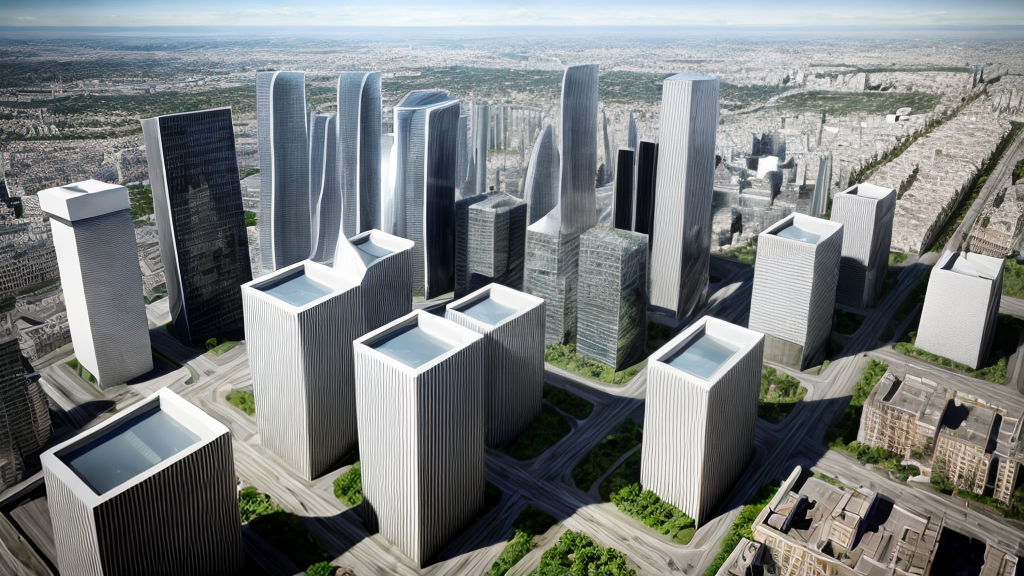

In [36]:
init_prompt = blocks[2]

# Make the image prompt.
gpt_prompt = betterfy_prompt.replace('@post', init_prompt)
print('Generating image prompt .. ', end='', flush=True)
gpt_reply = get_gpt_response(gpt_prompt)
print('done!')

# Generate the image.
print('Generating the image .. ')
img_url = ask_for_image_url(gpt_reply, num_inference_steps=51, width=1024, height=576, enhance_prompt='no')
img = display_image_from_url(img_url)
print('.. done!')
display(img)

In [37]:
print(blocks[2])

Now, our question is: where does French architecture go from here? As we stand on the precipice of a new era, what will the future hold? 

As we've seen, each architectural style born in France not only reflected but also influenced contemporary views. The grandeur of the Gothic period reflected a time of religious influence; the Art Nouveau emerged as an artistic response to the industrial revolution. Today's challenges and priorities – sustainability, technology and social changes – are expected to similarly shape French architecture's future. Current designs have already begun to reflect a societal shift towards sustainability and energy efficiency, and we can expect to see contemporary French architecture continue to develop in environmentally conscious ways.


In [14]:
for block in blocks:
    print('\n' + '_' * 80)
    print(block)


________________________________________________________________________________
Ladies and gentlemen, it's a pleasure to be here today to talk to you about a topic that is at once steeped in history, but full of potential for the future: the architecture of France. It's not just an exploration of aesthetics or engineering; French architecture offers a compelling narrative of the country's spirit, values, and evolution. As we venture to the future of French architecture, let's start by examining its storied past.

________________________________________________________________________________
If you've visited Paris, you've seen firsthand the chronicles of architectural achievement, from the Middle Ages to the 21st century. Paris was the birthplace of the Gothic style, evident in the majestic Cathedral Notre-Dame de Paris, and later gave the world the Art Nouveau style, with its organic and flowing designs. The city has witnessed a dramatic interplay of styles that represented differ

In [7]:
blocks = transcript.split('\n')
for block in blocks:

    if len(block.strip()) == 0:
        continue
    
    print()
    print('_' * 80)
    print(block)
    print(len(block))


________________________________________________________________________________
Ladies and gentlemen, it's a pleasure to be here today to talk to you about a topic that is at once steeped in history, but full of potential for the future: the architecture of France. It's not just an exploration of aesthetics or engineering; French architecture offers a compelling narrative of the country's spirit, values, and evolution. As we venture to the future of French architecture, let's start by examining its storied past.
437

________________________________________________________________________________
If you've visited Paris, you've seen firsthand the chronicles of architectural achievement, from the Middle Ages to the 21st century. Paris was the birthplace of the Gothic style, evident in the majestic Cathedral Notre-Dame de Paris, and later gave the world the Art Nouveau style, with its organic and flowing designs. The city has witnessed a dramatic interplay of styles that represented di